## Importing the packages

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='ticks', font_scale=1.25)

warnings.filterwarnings('ignore')

In [2]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, \
    classification_report, accuracy_score, precision_score, recall_score

## Importing Data

In [3]:
bankcalls = pd.read_excel('./BankCalls.xlsx')

## UDFs

In [4]:
def conti_var_summary(x):

    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total

    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr

    return pd.Series([
        x.dtype,
        x.nunique(), n_total,
        x.count(), n_miss, perc_miss,
        x.sum(),
        x.mean(),
        x.std(),
        x.var(), lc_iqr, uc_iqr,
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.5),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'dtype', 'cardinality', 'n_tot', 'n', 'nmiss',
                         'perc_miss', 'sum', 'mean', 'std', 'var', 'lc_iqr',
                         'uc_iqr', 'min', 'p1', 'p5', 'p10', 'p25', 'p50',
                         'p75', 'p90', 'p95', 'p99', 'max'
                     ])

In [5]:
def cat_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

## Data Inspection

In [6]:
bankcalls.columns

Index(['age', 'job', 'marital', 'housing', 'loan', 'month', 'duration',
       'campaign attending', 'Customer since ', 'previous Savings',
       'emp_var_rate', 'cons_price_idx', 'nr_employed', 'Output'],
      dtype='object')

In [7]:
bankcalls.isnull().sum()

age                   0
job                   0
marital               0
housing               0
loan                  0
month                 0
duration              0
campaign attending    0
Customer since        0
previous Savings      0
emp_var_rate          0
cons_price_idx        0
nr_employed           0
Output                0
dtype: int64

There is no missing data.

### Fixing the Column Names

In [8]:
bankcalls.rename(columns=lambda x: x.lower().strip().replace(" ", "_"),
                 inplace=True)

In [9]:
bankcalls.columns

Index(['age', 'job', 'marital', 'housing', 'loan', 'month', 'duration',
       'campaign_attending', 'customer_since', 'previous_savings',
       'emp_var_rate', 'cons_price_idx', 'nr_employed', 'output'],
      dtype='object')

### Checking the metadata

In [10]:
bankcalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 41188 non-null  int64  
 1   job                 41188 non-null  object 
 2   marital             41188 non-null  object 
 3   housing             41188 non-null  object 
 4   loan                41188 non-null  object 
 5   month               41188 non-null  object 
 6   duration            41188 non-null  int64  
 7   campaign_attending  41188 non-null  int64  
 8   customer_since      41188 non-null  int64  
 9   previous_savings    41188 non-null  int64  
 10  emp_var_rate        41188 non-null  float64
 11  cons_price_idx      41188 non-null  float64
 12  nr_employed         41188 non-null  float64
 13  output              41188 non-null  int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 4.4+ MB


### Attribute Information:
Source : [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

#### Input variables:
* *Bank client data:*
    1. **age** (numeric)
    2. **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3. **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4. **housing** : has housing loan? (categorical: 'no','yes','unknown')
    5. **loan** : has personal loan? (categorical: 'no','yes','unknown')


* *Related with the last contact of the current campaign:*
    6. **month** : last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    7. **duration** : last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


* *Other attributes:*
    8. **campaign_attending** : number of contacts performed during this campaign and for this client (numeric, includes last contact)
    9. **customer_since** : number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    10. **previous_savings** : number of contacts performed before this campaign and for this client (numeric)


* *Social and Economic context attributes:*
    11. **emp_var_rate** : employment variation rate. quarterly indicator (numeric)
    12. **cons_price_idx** : consumer price index. monthly indicator (numeric)
    13. **nr_employed** : number of employees. quarterly indicator (numeric)

#### Output variable (desired target):
* 
    14. **output** : has the client subscribed a term deposit? (binary: 'yes'[1], 'no'[0])



In [11]:
bankcalls.head()

,age,job,marital,housing,loan,month,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
0,44,blue-collar,married,yes,no,aug,210,1,999,0,1.4,93.444,5228.1,0
1,53,technician,married,no,no,nov,138,1,999,0,-0.1,93.200,5195.8,0
2,28,management,single,yes,no,jun,339,3,6,2,-1.7,94.055,4991.6,1
3,39,services,married,no,no,apr,185,2,999,0,-1.8,93.075,5099.1,0
4,55,retired,married,yes,no,aug,137,1,3,1,-2.9,92.201,5076.2,1


### Distribution of the Output variable

In [12]:
bankcalls.output.value_counts() / bankcalls.output.notna().sum()

0    0.887346
1    0.112654
Name: output, dtype: float64

In [13]:
bankcalls.shape

(41188, 14)

In [14]:
# EDA for all the variables
bankcalls.select_dtypes(['int64', 'float64']).apply(conti_var_summary)

,age,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
dtype,int64,int64,int64,int64,int64,float64,float64,float64,int64
cardinality,78,1544,42,27,8,10,26,11,2
n_tot,41188,41188,41188,41188,41188,41188,41188,41188,41188
n,41188,41188,41188,41188,41188,41188,41188,41188,41188
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,1648511,10638243,105754,39642439,7124,3372.7,3854194.464,212819875.1,4640
mean,40.02406,258.28501,2.567593,962.475454,0.172963,0.081886,93.575664,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.57096,0.57884,72.251528,0.316173
var,108.602451,67225.728877,7.672975,34935.687284,0.244927,2.467915,0.335056,5220.28325,0.099966


Outliers exists. Value-wise no other anomalies found.

In [15]:
bankcalls.select_dtypes(['object']).apply(cat_var_summary)

,job,marital,housing,loan,month
N,41188,41188,41188,41188,41188
NMISS,0,0,0,0,0
MODE,admin.,married,yes,no,may
FREQ,10422,24928,21576,33950,13769
PERCENT,25.3,60.52,52.38,82.43,33.43


## Plots

AGE
skewness = 0.7846968157646645


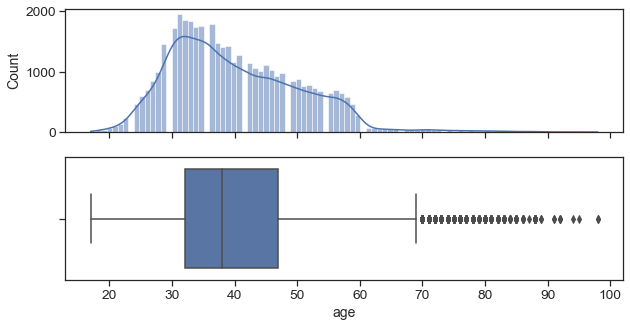

JOB


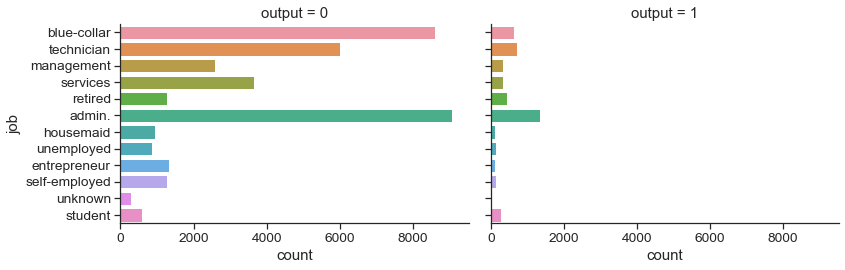

MARITAL


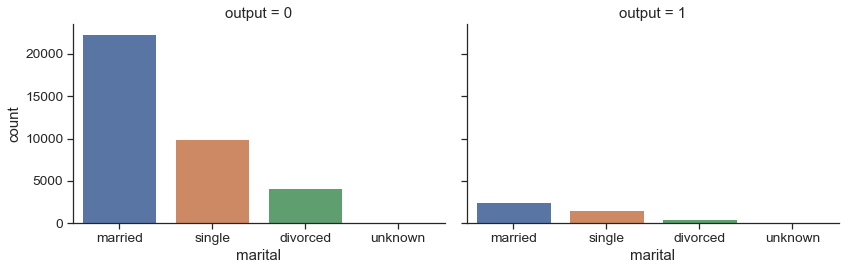

HOUSING


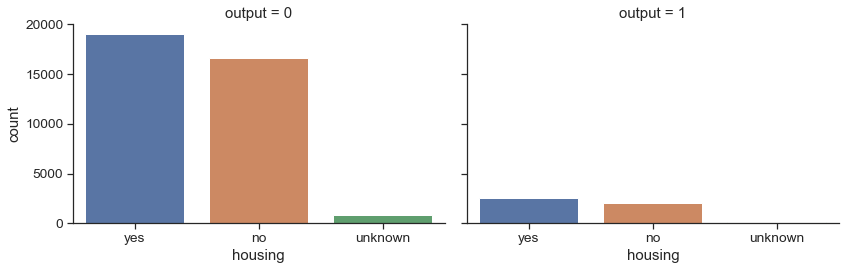

LOAN


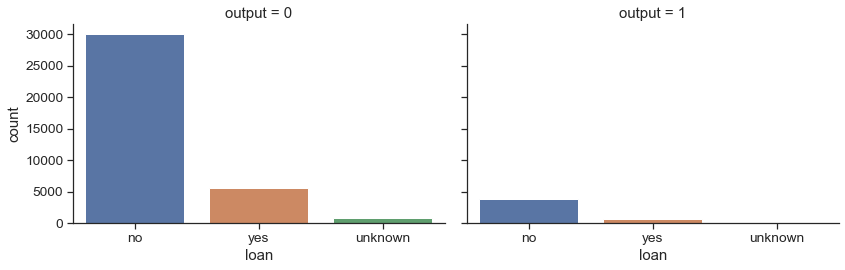

MONTH


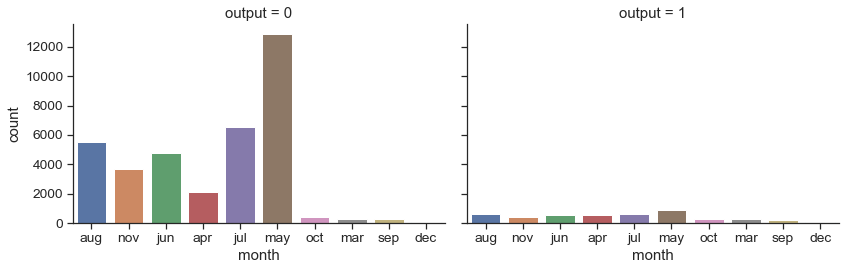

DURATION
skewness = 3.2631412552628314


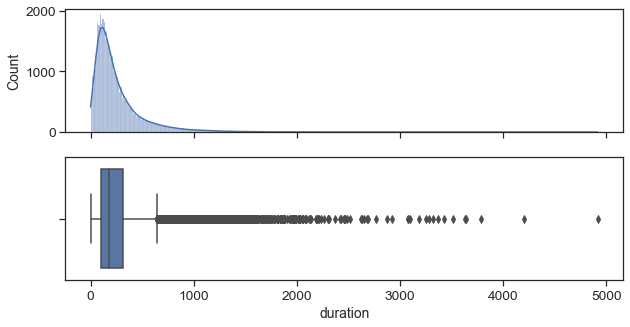

CAMPAIGN_ATTENDING
skewness = 4.762506697067007


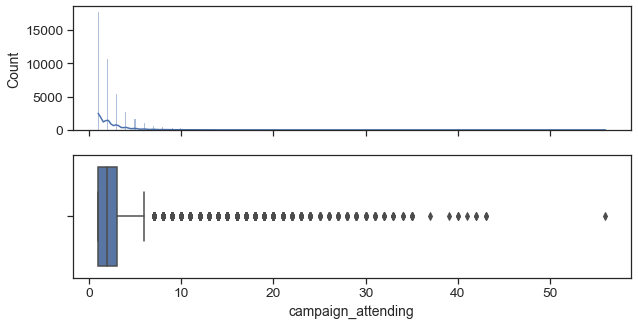

CUSTOMER_SINCE
skewness = -4.922189916418164


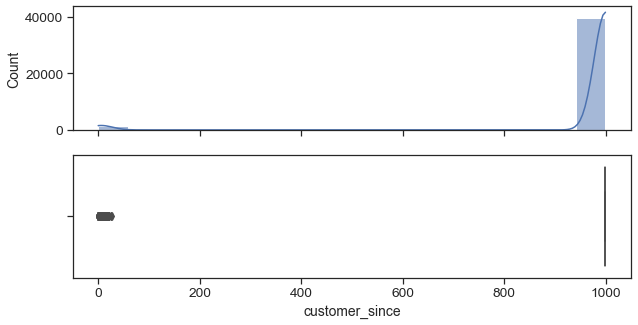

PREVIOUS_SAVINGS
skewness = 3.8320422428611836


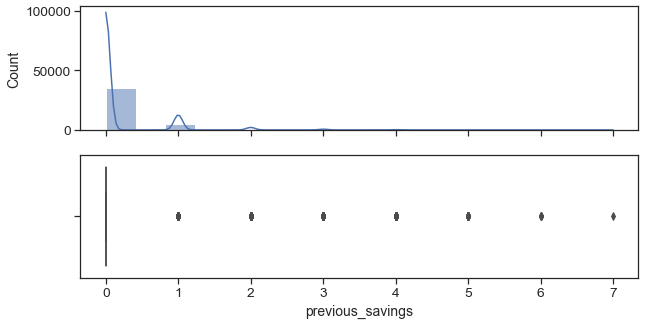

EMP_VAR_RATE
skewness = -0.7240955492472559


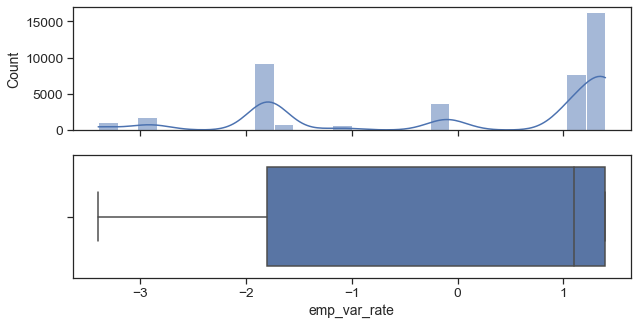

CONS_PRICE_IDX
skewness = -0.2308876513578066


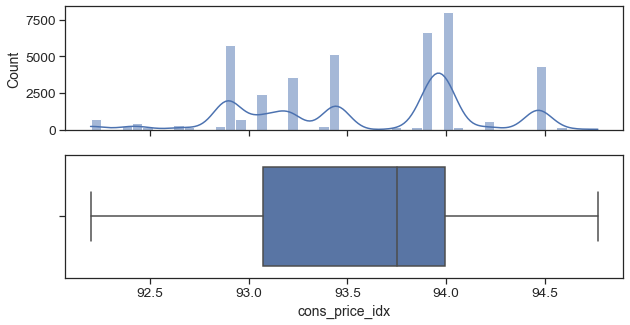

NR_EMPLOYED
skewness = -1.044262407089151


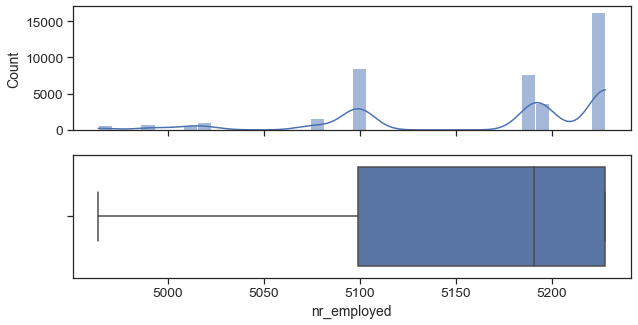

OUTPUT
skewness = 2.4503301382077263


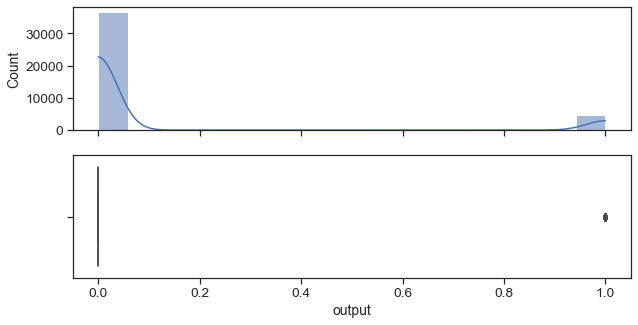

In [16]:
# Getting the distributions of all continuous variables and Count Plots for Categorical variables
for i in bankcalls.columns:
    try:
        print(i.upper(), '\nskewness = ', bankcalls.loc[:, i].skew(), sep='')
        params = {'figure.figsize': (10, 5), 'axes.labelsize': 14}
        plt.rcParams.update(params)
        fig, axs = plt.subplots(2, 1, sharex=True)
        sns.histplot(data=bankcalls, x=i, kde=True, ax=axs[0])
        sns.boxplot(x=bankcalls.loc[:, i], ax=axs[1])
        plt.show()
    except:
        print(i.upper())
        params = {'figure.figsize': (10, 5), 'axes.labelsize': 14}
        plt.rcParams.update(params)
        sns.set(style='ticks', font_scale=1.25)
        if i != 'job':
            sns.catplot(x=i,
                        col='output',
                        data=bankcalls,
                        kind='count',
                        height=4,
                        aspect=1.5)
        else:
            sns.catplot(y=i,
                        col='output',
                        data=bankcalls,
                        kind='count',
                        height=4,
                        aspect=1.5)
        plt.show()

## Data Preparation / Data Cleaning

### Outlier Treatment

In [17]:
bankcalls_conti = bankcalls.select_dtypes(['int64', 'float64']).apply(lambda x: x.clip(lower=x.quantile(0.01),
                                                                                       upper=x.quantile(0.99)))

In [18]:
bankcalls = pd.concat([bankcalls.select_dtypes(['object']), bankcalls_conti], axis=1)
bankcalls.head()

,job,marital,housing,loan,month,age,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
0,blue-collar,married,yes,no,aug,44.0,210.0,1.0,999.0,0.0,1.4,93.444,5228.1,0
1,technician,married,no,no,nov,53.0,138.0,1.0,999.0,0.0,-0.1,93.200,5195.8,0
2,management,single,yes,no,jun,28.0,339.0,3.0,6.0,2.0,-1.7,94.055,4991.6,1
3,services,married,no,no,apr,39.0,185.0,2.0,999.0,0.0,-1.8,93.075,5099.1,0
4,retired,married,yes,no,aug,55.0,137.0,1.0,3.0,1.0,-2.9,92.201,5076.2,1


In [19]:
bankcalls.select_dtypes(['int64', 'float64']).apply(conti_var_summary)

,age,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
dtype,float64,float64,float64,float64,float64,float64,float64,float64,int64
cardinality,49,1219,14,24,3,10,24,11,2
n_tot,41188,41188,41188,41188,41188,41188,41188,41188,41188
n,41188,41188,41188,41188,41188,41188,41188,41188,41188
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,1646558.0,10477394.56,102971.0,39642597.0,6689.0,3372.7,3854128.064,212819875.1,4640
mean,39.976644,254.379784,2.500024,962.47929,0.162402,0.081886,93.574052,5167.035911,0.112654
std,10.138262,235.184174,2.301191,186.891194,0.433241,1.57096,0.57603,72.251528,0.316173
var,102.784362,55311.595654,5.295482,34928.31858,0.187697,2.467915,0.331811,5220.28325,0.099966


### Treating the `Unknown`s

In [20]:
l = []
for i in bankcalls.select_dtypes('object').columns:
    try:
        a = bankcalls[i].value_counts().unknown
        b = bankcalls[i].value_counts().unknown / bankcalls[i].count() * 100
        l.append((i, a, b))
    except:
        pass
df_u = pd.DataFrame(l, columns=['Category', 'Unkown', '%']).set_index('Category')
df_u

,Unkown,%
Category,,
job,330,0.801204
marital,80,0.194231
housing,990,2.403613
loan,990,2.403613


Since the % of `unknown` is very less we can drop those rows.

In [21]:
# Dropping Unknowns
print(bankcalls.shape)
bankcalls.replace('unknown', np.NAN, inplace=True)
bankcalls.dropna(inplace=True)
print(bankcalls.shape)

(41188, 14)
(39803, 14)


In [22]:
l = []
for i in bankcalls.select_dtypes('object').columns:
    try:
        a = bankcalls[i].value_counts().unknown
        b = bankcalls[i].value_counts().unknown / bankcalls[i].count() * 100
        l.append((i, a, b))
    except:
        pass
df_u = pd.DataFrame(l, columns=['Category', 'Unkown', '%']).set_index('Category')
df_u

,Unkown,%
Category,,


All Unknowns are removed successfully.

## Creating Dummies for the Categorical Columns (One-Hot-Encoding)

In [23]:
bankcalls = pd.get_dummies(bankcalls, drop_first=True).reset_index(drop=True)

In [24]:
# Fixing the column names

bankcalls.rename(columns=lambda x: x.lower().strip().replace("-", "_"),
                 inplace=True)

In [25]:
bankcalls

,age,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output,job_blue_collar,...,loan_yes,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,44.0,210.0,1.0,999.0,0.0,1.4,93.444,5228.1,0,1,...,0,1,0,0,0,0,0,0,0,0
1,53.0,138.0,1.0,999.0,0.0,-0.1,93.200,5195.8,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28.0,339.0,3.0,6.0,2.0,-1.7,94.055,4991.6,1,0,...,0,0,0,0,1,0,0,0,0,0
3,39.0,185.0,2.0,999.0,0.0,-1.8,93.075,5099.1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55.0,137.0,1.0,3.0,1.0,-2.9,92.201,5076.2,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39798,59.0,222.0,1.0,999.0,0.0,1.4,94.465,5228.1,0,0,...,1,0,0,0,1,0,0,0,0,0
39799,31.0,196.0,2.0,999.0,0.0,1.1,93.994,5191.0,0,0,...,0,0,0,0,0,0,1,0,0,0
39800,42.0,62.0,3.0,999.0,0.0,1.1,93.994,5191.0,0,0,...,1,0,0,0,0,0,1,0,0,0
39801,48.0,200.0,2.0,999.0,0.0,-3.4,92.431,5017.5,0,0,...,1,0,0,0,0,0,0,0,1,0


## Bi-variate analysis to identify corr

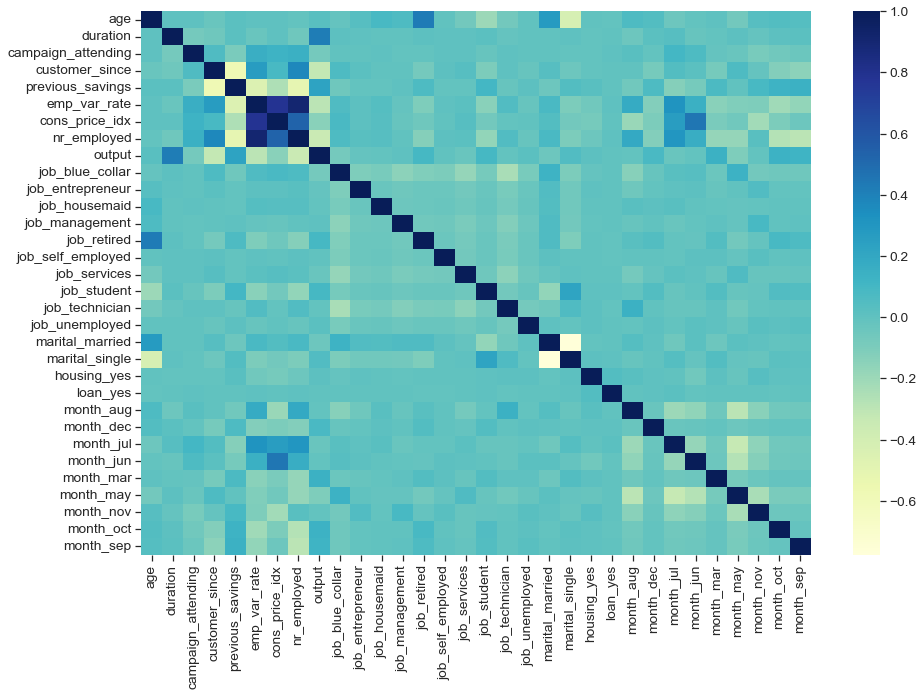

In [26]:
# Visualizing correlation matrix in Seaborn using a heatmap
bankcalls.corr().to_excel('bankcalls_corr.xlsx')
plt.figure(figsize=(15, 10))
sns.heatmap(bankcalls.corr(), annot=False, cmap='YlGnBu')
plt.show()

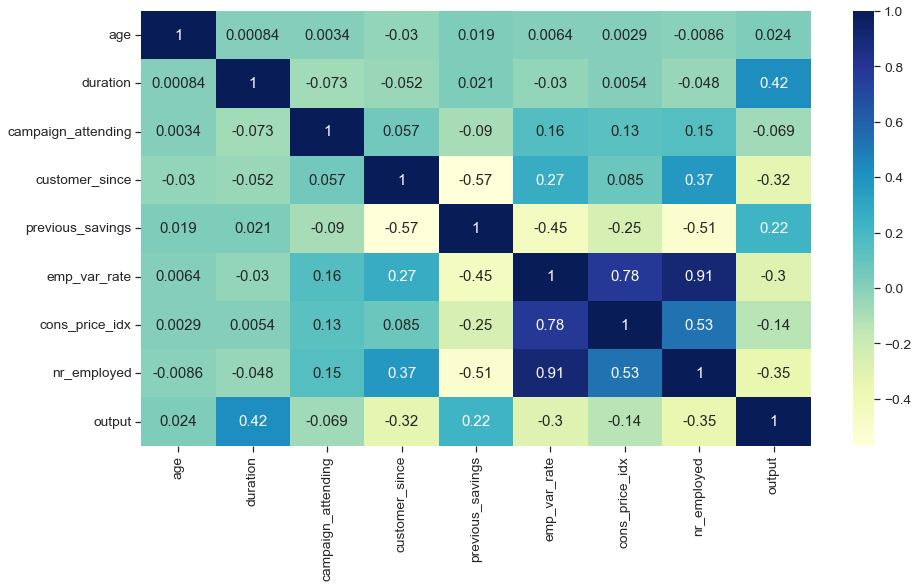

In [27]:
plt.figure(figsize=(15, 8))
sns.heatmap(bankcalls.select_dtypes(['int64', 'float64']).corr(), annot=True, cmap='YlGnBu')
plt.show()

* `cons_price_idx` and `nr_employed` are highly co-related with `emp_var_rate`.

## Building Logistic Regression Model

In [28]:
# Train and Test split
train, test = train_test_split(bankcalls,
                               test_size=0.3,
                               random_state=2,
                               stratify=bankcalls.output)

In [29]:
# Printing the columns
train.columns

Index(['age', 'duration', 'campaign_attending', 'customer_since',
       'previous_savings', 'emp_var_rate', 'cons_price_idx', 'nr_employed',
       'output', 'job_blue_collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self_employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'housing_yes', 'loan_yes', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep'],
      dtype='object')

In [30]:
model_eq = 'output ~ ' + ' + '.join(train.columns.difference(['output']))
model_eq

'output ~ age + campaign_attending + cons_price_idx + customer_since + duration + emp_var_rate + housing_yes + job_blue_collar + job_entrepreneur + job_housemaid + job_management + job_retired + job_self_employed + job_services + job_student + job_technician + job_unemployed + loan_yes + marital_married + marital_single + month_aug + month_dec + month_jul + month_jun + month_mar + month_may + month_nov + month_oct + month_sep + nr_employed + previous_savings'

In [31]:
# Executing a model for the X variables
m1 = smf.logit(formula=model_eq, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.202991
         Iterations 9


In [32]:
# Printing the model summary stats
print(m1.summary2())

                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.424     
Dependent Variable:     output             AIC:                11375.4750
Date:                   2022-09-03 02:51   BIC:                11638.9956
No. Observations:       27862              Log-Likelihood:     -5655.7   
Df Model:               31                 LL-Null:            -9812.8   
Df Residuals:           27830              LLR p-value:        0.0000    
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         9.0000                                           
-------------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
-------------------------------------------------------------------------
Intercept          -175.7590  32.8001  -5.3585 0.0000 -240.0460 -111.4720
age                  -0.0023   0.0030  -0.7695 0.4416   -0.0083    0

>* **Exploratory Data Analysis**
>  - Checking Optimum no of features using RFE
>  - Variable Reduction using Somers' D values and VIF
      - Bi-variate analysis technique to check the predictive power of each independent against dependent
      - cutoff is 0.2 or 20% below which the variable is insignificant
>  - Fixing the problem of Multi-collinearity using VIF
      - cutoff is 4, the variable is significant only if VIF < 4

### Checking Optimum no of features using RFE

Optimum number of features: 30
Score with 30 features: 0.910662


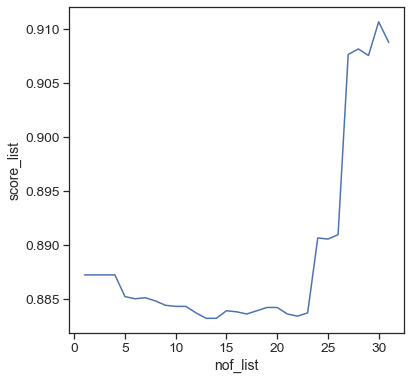

In [33]:
X_vars = bankcalls.columns.difference(['output'])
y_var = 'output'
X, y = bankcalls[X_vars], bankcalls[y_var]
X = pd.get_dummies(X, drop_first=True)
y_act = y
nof_list = np.arange(1, bankcalls.shape[1])
high_score = 0

# Variable to store the optimum features
nof = 0
score_list = []
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=2,
                                                    stratify=y)
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n], step=1)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if (score > high_score):
        high_score = score
        nof = nof_list[n]
        # print(np.array(X_train.columns)[rfe.support_])

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
plt.figure(figsize=(6, 6))
sns.lineplot(data=pd.DataFrame(np.array([nof_list, score_list]).T,
                               columns=['nof_list', 'score_list']),
             x='nof_list',
             y='score_list',
             markers=True,
             dashes=False)
plt.show()

Since there are lots of dummy variables in this data set and multi-collinearity exists between a few continuous variables, it is not feasible to get the optimum no. of features from RFE directly. We need to check for interdependency among the variables with different combinations in this case. So, it will be better to check with corresponding Somers' D values > 0.2 and then filtering recursively with VIF < 4.

### Getting the Somers' D values for all the X variables

In [34]:
# Empty dataframe to store the information
df = pd.DataFrame()

# Iterating on each X variable
for var_name in bankcalls.columns.difference(['output']):

    # Building the bivariate model and fit
    model = smf.logit(formula='output ~ ' + var_name, data=bankcalls).fit()

    # Predicting the y
    y_predicted = model.predict(bankcalls)

    # Getting the roc_auc_score
    roc_score = roc_auc_score(bankcalls.output, y_predicted)

    # Getting the Somers' D value
    somers_d = 2 * roc_score - 1

    # Storing the data in temp df
    temp_df = pd.DataFrame([var_name, roc_score, somers_d]).T

    # Concating the data with the output dataframe
    df = pd.concat([df, temp_df], axis=0)

# Adding the column names
df.columns = ['Feature', 'ROC_AUC_SCORE', 'SomersD']

Optimization terminated successfully.
         Current function value: 0.351895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.287685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352164
  

In [35]:
df.reset_index(drop=True, inplace=True)
df

,Feature,ROC_AUC_SCORE,SomersD
0,age,0.489237,-0.021526
1,campaign_attending,0.553545,0.107089
2,cons_price_idx,0.611982,0.223964
3,customer_since,0.596502,0.193005
4,duration,0.818546,0.637092
5,emp_var_rate,0.716108,0.432217
6,housing_yes,0.509203,0.018406
7,job_blue_collar,0.549694,0.099389
8,job_entrepreneur,0.504991,0.009982
9,job_housemaid,0.501618,0.003237


In [36]:
features = list(df.loc[df.SomersD >= 0.2, 'Feature'])
features

['cons_price_idx',
 'duration',
 'emp_var_rate',
 'nr_employed',
 'previous_savings']

### VIF - Variance Inflation Factor

In [37]:
def vif_fun(df, features):
    # Running the dmatrices
    equation = 'output ~ ' + ' + '.join(features)

    a, b = dmatrices(equation, data=df, return_type='dataframe')

    # Getting the VIF
    vif = pd.DataFrame()
    vif["features"] = b.columns
    vif["VIF Factor"] = [variance_inflation_factor(b.values, i) 
                         for i in range(b.shape[1])]
    pd.options.display.float_format = '{:.2f}'.format
    return vif

In [38]:
vif_fun(bankcalls, features)

,features,VIF Factor
0,Intercept,286831.61
1,cons_price_idx,4.67
2,duration,1.00
3,emp_var_rate,18.89
4,nr_employed,10.73
5,previous_savings,1.35


From the `corr()` values we have seen that both `cons_price_idx` and `nr_employed` are highly co-related with `emp_var_rate`. In VIF analysis `emp_var_rate` is having the maximum VIF factor. Hence this column should be dropped and we need to check the VIF factors again to make sure that all the features have VIF < 4.

In [39]:
# Based on the VIF factor, selected features are :
features = ['cons_price_idx', 'nr_employed', 'duration', 'previous_savings']
vif_fun(bankcalls, features)

,features,VIF Factor
0,Intercept,28360.07
1,cons_price_idx,1.40
2,nr_employed,1.77
3,duration,1.00
4,previous_savings,1.35


All the features have VIF < 4. Hence, we can proceed with the model building process.

### Building the actual model

In [40]:
features

['cons_price_idx', 'nr_employed', 'duration', 'previous_savings']

In [41]:
model_eq = 'output ~ ' + ' + '.join(features)
m2 = smf.logit(model_eq, data=train).fit()
print(m2.summary2())

Optimization terminated successfully.
         Current function value: 0.223640
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.365     
Dependent Variable:  output           AIC:              12472.1418
Date:                2022-09-03 02:52 BIC:              12513.3169
No. Observations:    27862            Log-Likelihood:   -6231.1   
Df Model:            4                LL-Null:          -9812.8   
Df Residuals:        27857            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975] 
------------------------------------------------------------------
Intercept        97.2830   3.7608  25.8676 0.0000 89.9120 104.6541
cons_price_idx   -0.2319   0.0390  -5.9474 0.0000 -0.

We can see that all the Variables are significant as `P>|z| < 0.05`.

## Predicting the values 

In [42]:
# Predicting the values on training and testing
train_predict = m2.predict(train)
test_predict = m2.predict(test)

In [43]:
train_predict.head(5)

25670   0.03
15664   0.01
15733   0.35
2028    0.05
37412   0.33
dtype: float64

## Model Scoring

In [44]:
# Combining the y actual and y predicted
train_data = pd.concat([train.output, train_predict], axis=1)
test_data = pd.concat([test.output, test_predict], axis=1)

train_data.columns = ['y_actual', 'y_pred_proba']
test_data.columns = ['y_actual', 'y_pred_proba']

In [45]:
# roc_auc_score
concordance_train = roc_auc_score(train_data.y_actual, train_data.y_pred_proba)
concordance_test = roc_auc_score(test_data.y_actual, test_data.y_pred_proba)

print('Train:', concordance_train, '| Test: ', concordance_test)

Train: 0.9149187195900261 | Test:  0.9149726839947352


### Finding the model accuracy at cutoff 0.5

In [46]:
train_data['y_pred'] = np.where(train_data.y_pred_proba >= 0.5, 1, 0)

#### Confusion Matrix

In [47]:
# confusion matrix (using crosstab)
pd.crosstab(train_data.y_actual, train_data.y_pred).loc[::-1, ::-1]

y_pred,1,0
y_actual,,
1,1084,2057
0,643,24078


In [48]:
# confusion matrix (using sklearn.metrics)
cm_p50 = confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]

tp = cm_p50[0, 0]
tn = cm_p50[1, 1]
fp = cm_p50[1, 0]
fn = cm_p50[0, 1]

accuracy = (tp + tn) / cm_p50.sum()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(cm_p50)
print('accuracy: ', accuracy, '| tpr: ', tpr, '| fpr: ', fpr)

[[ 1084  2057]
 [  643 24078]]
accuracy:  0.9030938195391572 | tpr:  0.34511302133078636 | fpr:  0.02601027466526435


#### Classification Report

In [49]:
print(classification_report(train_data.y_actual, train_data.y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     24721
           1       0.63      0.35      0.45      3141

    accuracy                           0.90     27862
   macro avg       0.77      0.66      0.70     27862
weighted avg       0.89      0.90      0.89     27862



### Getting the best Cut-offs 
Based on :
1. Accuracy, 
2. [ Sensitivity + Specificity ]

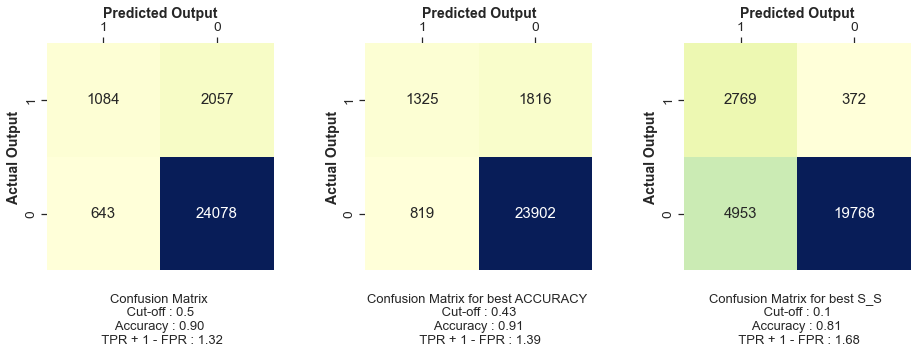

In [50]:
# Empty dataframe to store the information
cm_scores = pd.DataFrame()

# Loop for different probability values
for prob_val in np.arange(0, 1.01, 0.01):

    # Getting the y_pred
    train_data['y_pred'] = np.where(train_data.y_pred_proba >= prob_val, 1, 0)

    # Getting the confusion matrix
    cm = confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]

    # Getting the metric values
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]

    accuracy = (tp + tn) / cm.sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    s_s = tpr + 1 - fpr

    # Storing the data in temp dataframe
    temp_df = pd.DataFrame([prob_val, tp, tn, fp, fn, accuracy, tpr, fpr,
                            s_s]).T

    # Adding the data to final dataframe
    cm_scores = pd.concat([cm_scores, temp_df], axis=0)

# Adding the column names
cm_scores.columns = [
    'prob_val', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'tpr', 'fpr', 's_s'
]

# Creating Heatmap
class_names = [0, 1]
fig, axs = plt.subplots(1, 3, figsize=(13.5, 5))
plt.subplots_adjust(wspace=0, hspace=0)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
best_cutoff = {}
j = 0
for i in ['random', 'accuracy', 's_s']:
    if i == 'random':
        best_cutoff[i] = 0.5
        cm_best_df = pd.DataFrame(cm_p50, index=[1, 0], columns=[1, 0])
        acc_ = cm_scores[cm_scores.prob_val == 0.5].accuracy[0]
        s_s_ = cm_scores[cm_scores.prob_val == 0.5].s_s[0]
    else:
        # Getting the best cutoff
        cm_scores_ = cm_scores.sort_values(by=[i, 'fn'],
                                           ascending=[False, True]).head(1)
        best_cutoff[i] = cm_scores_.loc[:, 'prob_val'][0]
        cm_best = cm_scores_.loc[:, ['tp', 'tn', 'fp', 'fn']]
        pd.options.display.float_format = '{:.0f}'.format
        cm_best_df = pd.DataFrame(np.array(
            [[cm_best.loc[0][0], cm_best.loc[0][3]],
             [cm_best.loc[0][2], cm_best.loc[0][1]]]),
            index=[1, 0],
            columns=[1, 0])
        acc_ = cm_scores_.accuracy[0]
        s_s_ = cm_scores_.s_s[0]

    # Plotting the Heat-map
    sns.heatmap(cm_best_df,
                annot=True,
                cmap="YlGnBu",
                fmt='g',
                ax=axs[j],
                cbar=False,
                square=True)
    axs[j].xaxis.tick_top()
    axs[j].xaxis.set_label_position("top")
    if i == 'random':
        axs[j].set_title(
            f'Confusion Matrix \n Cut-off : {best_cutoff[i]} \n Accuracy : {acc_:.2f} \n TPR + 1 - FPR : {s_s_:.2f}',
            y=-0.35,
            fontsize=13)
    else:
        axs[j].set_title(
            f'Confusion Matrix for best {i.upper()} \n Cut-off : {best_cutoff[i]} \n Accuracy : {acc_:.2f} \n TPR + 1 - FPR : {s_s_:.2f}',
            y=-0.35,
            fontsize=13)
    axs[j].set_ylabel('Actual Output', fontsize=14, fontweight='bold')
    axs[j].set_xlabel('Predicted Output', fontsize=14, fontweight='bold')
    j += 1
fig.tight_layout()
plt.show()

As per the business problem our target is to decrease the FN count to get maximum of the customers who are willing to subscribe to the bank Scheme and also need to decrease FP to control the campaign costs for the bank.Now, if the Bank is willing to invest more in campaigns, then we need to choose the cut off with **max `s_s` [Sensitivity + Specificity = TPR + 1 - FPR]**, otherwise we can proceed with the cut off with **max `accuracy`**.

Here, the cut off with **max `accuracy`** is chosen.

In [51]:
cutoff_chosen = best_cutoff['accuracy']
#cutoff_chosen = best_cutoff['s_s']
cutoff_chosen

0.43

### Final predictions at best cutoff

In [52]:
train_data['y_pred'] = np.where(train_data.y_pred_proba >= cutoff_chosen, 1, 0)
test_data['y_pred'] = np.where(test_data.y_pred_proba >= cutoff_chosen, 1, 0)

### Classification report at best cutoff

In [53]:
print('TRAIN DATA')
print(classification_report(train_data.y_actual, train_data.y_pred))
print('-----------------------------------------------------')
print('TEST DATA')
print(classification_report(test_data.y_actual, test_data.y_pred))

TRAIN DATA
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     24721
           1       0.62      0.42      0.50      3141

    accuracy                           0.91     27862
   macro avg       0.77      0.69      0.72     27862
weighted avg       0.89      0.91      0.90     27862

-----------------------------------------------------
TEST DATA
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10595
           1       0.63      0.43      0.51      1346

    accuracy                           0.91     11941
   macro avg       0.78      0.70      0.73     11941
weighted avg       0.90      0.91      0.90     11941



### Model Performance in Test data

In [54]:
print("Train Accuracy:", accuracy_score(train_data.y_actual, train_data.y_pred))
print("Test Accuracy:", accuracy_score(test_data.y_actual, test_data.y_pred))
print("Test Precision:", precision_score(test_data.y_actual, test_data.y_pred))
print("Test Recall:", recall_score(test_data.y_actual, test_data.y_pred))

Train Accuracy: 0.9054267461058072
Test Accuracy: 0.9067079809061218
Test Precision: 0.6263616557734205
Test Recall: 0.42719167904903416


<p style="background-color:SeaGreen; color:White; text-align: center; font-size:16px; font-family:Monospace"><b>
##########################################################<br>
## Train Accuracy = Test Accuracy. The model is stable. ##<br>
##########################################################
</p>


### Plotting the ROC Curve 

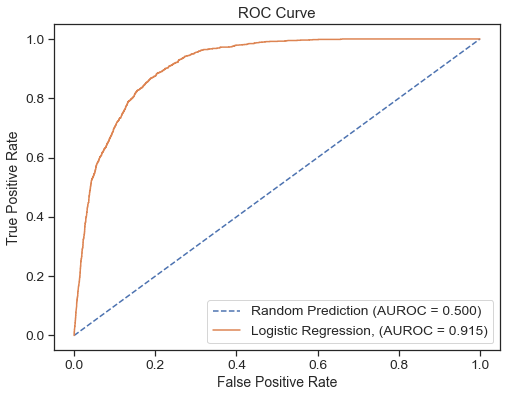

In [55]:
plt.figure(figsize=(8, 6))
r_auc = [0 for i in range(len(test_data.y_actual))]
r_fpr, r_tpr, _ = roc_curve(test_data.y_actual, r_auc)
r_auc = roc_auc_score(test_data.y_actual, r_auc)
plt.plot(r_fpr,
         r_tpr,
         linestyle="--",
         label="Random Prediction (AUROC = %0.3f)" % r_auc)

fpr, tpr, _ = roc_curve(test_data.y_actual, test_data.y_pred_proba)
auc = roc_auc_score(test_data.y_actual, test_data.y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regression, (AUROC = %0.3f)" % auc)

plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Decile Analysis

**Decile Range : [0 - 9]**
- Top-5 deciles - Low gain customers - will not open Savings Scheme
- 5th to 8th deciles - Medium gain customers - will open Savings Scheme with proper scrutiny
- 9th decile only - High gain customers - will open Savings Scheme

In [56]:
# Decile analysis for validation of models - Business validation
train_data['Deciles'] = pd.qcut(train_data.y_pred_proba, 10, labels=False)
test_data['Deciles'] = pd.qcut(test_data.y_pred_proba, 10, labels=False)

### Decile Analysis for train data

In [57]:
train_deciles = train_data.groupby('Deciles')[[
    'y_pred_proba', 'y_actual'
]].agg({
    'y_pred_proba': ['min', 'max'],
    'y_actual': ['sum', 'count']
}).reset_index().sort_values(by='Deciles', ascending=False)
train_deciles

Deciles y_pred_proba     y_actual      
                   min max      sum count
9       9            0   1     1634  2787
8       8            0   0      799  2786
7       7            0   0      405  2779
6       6            0   0      188  2783
5       5            0   0       73  2795
4       4            0   0       20  2785
3       3            0   0       15  2784
2       2            0   0        6  2780
1       1            0   0        1  2788
0       0            0   0        0  2795

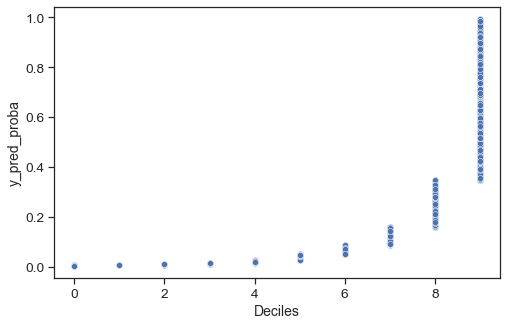

In [58]:
plt.figure(figsize=(8, 5))
sns.scatterplot(train_data.Deciles, train_data.y_pred_proba);

### Decile Analysis for test data

In [59]:
test_deciles = test_data.groupby('Deciles')[['y_pred_proba', 'y_actual']].agg({
    'y_pred_proba': ['min', 'max'],
    'y_actual': ['sum', 'count']
}).reset_index().sort_values(by='Deciles', ascending=False)
test_deciles

Deciles y_pred_proba     y_actual      
                   min max      sum count
9       9            0   1      713  1194
8       8            0   0      325  1194
7       7            0   0      171  1194
6       6            0   0       89  1192
5       5            0   0       27  1191
4       4            0   0       14  1199
3       3            0   0        7  1194
2       2            0   0        0  1193
1       1            0   0        0  1193
0       0            0   0        0  1197

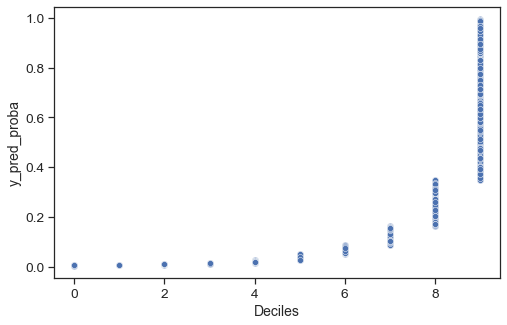

In [60]:
plt.figure(figsize=(8, 5))
sns.scatterplot(test_data.Deciles, test_data.y_pred_proba);

### Histogram of predicted probabilities

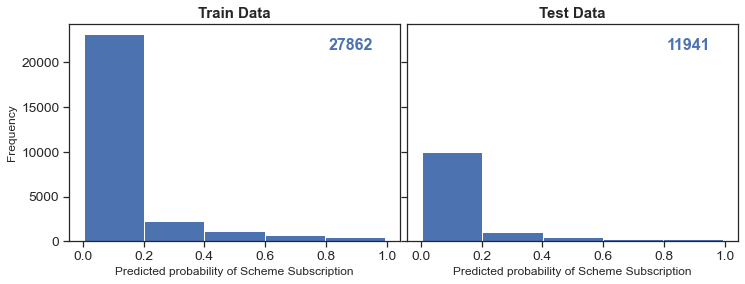

In [61]:
params = {'figure.figsize': (12, 4), 'axes.labelsize': 12}
plt.rcParams.update(params)
fig, axs = plt.subplots(1, 2, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0)
# Train
axs[0].hist(train_data.y_pred_proba, bins=5)
axs[0].set_title('Train Data', fontdict={'fontsize': 15, 'fontweight': 'bold'})
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Predicted probability of Scheme Subscription')
axs[0].text(0.85,
            0.9,
            str(train.shape[0]),
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[0].transAxes,
            fontsize=16,
            fontweight='bold',
            color='b')
# Test
axs[1].hist(test_data.y_pred_proba, bins=5)
axs[1].set_title('Test Data', fontdict={'fontsize': 15, 'fontweight': 'bold'})
axs[1].set_xlabel('Predicted probability of Scheme Subscription')
axs[1].text(0.85,
            0.9,
            str(test.shape[0]),
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[1].transAxes,
            fontsize=16,
            fontweight='bold',
            color='b')
plt.show()

### Checking the Ratios of Output variables in Total, Train, Test

In [62]:
pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame([
    bankcalls.output.value_counts() / bankcalls.output.notna().sum(),
    train_data.y_actual.value_counts() / train_data.y_actual.notna().sum(),
    test_data.y_actual.value_counts() / test_data.y_actual.notna().sum()
],
             index=['Total Dataset', 'Train', 'Test'])

,0,1
Total Dataset,0.8873,0.1127
Train,0.8873,0.1127
Test,0.8873,0.1127


Although the output variable is split in a stratified manner in both Train and Test, the real Problem with the dataset is that the dataset is unbalanced with 89% data with Output 0 and 11% with Output 1. Hence, the model is better trained to predict which customers will not consider taking the Scheme.

## Significant Features

### By ROC_AUC_SCORE

In [63]:
df[df.Feature.isin(features)].sort_values(by='ROC_AUC_SCORE', ascending = False).reset_index(drop=True)

,Feature,ROC_AUC_SCORE,SomersD
0,duration,0.8185,0.6371
1,nr_employed,0.7480,0.4961
2,cons_price_idx,0.6120,0.2240
3,previous_savings,0.6075,0.2150


### Calculating Odds Ratios

In [64]:
odds_ratios = pd.DataFrame({
    "Odds Ratio": m2.params,
    "Lower CI": m2.conf_int()[0],
    "Upper CI": m2.conf_int()[1],
})
odds_ratios = np.exp(odds_ratios)
pd.reset_option('^display.', silent=True)
print(odds_ratios)

                    Odds Ratio      Lower CI      Upper CI
Intercept         1.776172e+42  1.117601e+39  2.822822e+45
cons_price_idx    7.930571e-01  7.347171e-01  8.560296e-01
nr_employed       9.846364e-01  9.839358e-01  9.853375e-01
duration          1.005014e+00  1.004838e+00  1.005189e+00
previous_savings  1.271842e+00  1.169489e+00  1.383152e+00


### By p-values for z-scores

In [65]:
pd.options.display.float_format = '{:.5f}'.format
results_as_html = m2.summary().tables[1].as_html()
ms = (pd.read_html(results_as_html, header=0,
                   index_col=0)[0]).sort_values(by='P>|z|')
ms_significant = ms[(ms['P>|z|'] < 0.05) | (ms.index == 'Intercept')]
print(ms_significant.shape[0]-1)
ms_significant.sort_values(by='coef', ascending=False)

4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,97.28300,3.76100,25.86800,0.00000,89.91200,104.65400
previous_savings,0.24050,0.04300,5.61800,0.00000,0.15700,0.32400
duration,0.00500,0.00009,56.11100,0.00000,0.00500,0.00500
nr_employed,-0.01550,0.00000,-42.63200,0.00000,-0.01600,-0.01500
cons_price_idx,-0.23190,0.03900,-5.94700,0.00000,-0.30800,-0.15500


In [66]:
# Intercept Value
ms_significant.T.Intercept[0]

97.283

### Final Comments

> <p style="color:Blue; font-size:16px;"><b>MODEL DETAILS</b></p>

>Logistic Regression : 
`statsmodels.formula.api.logit` <br>
CUT-OFF : 0.43 (BEST Accuracy) <br>
TRAIN ACCURACY : 0.91 <br>
TEST ACCURACY : 0.91 <br>
TEST PRECISION : 0.63 <br>
TEST RECALL : 0.43 <br>
TEST F1-SCORE : 0.51
<br>

> <p style="color:Red; font-size:16px;"><b>SIGNIFICANT VARIABLES</b></p>

> So, while campaigning for new Savings Scheme the bank may focus on : 
> 1. **previous_savings** : number of contacts performed before this campaign and for this client (numeric)
> 2. **cons_price_idx** : consumer price index. monthly indicator (numeric)
> 3. **nr_employed** : number of employees. quarterly indicator (numeric)
> 4. **duration** : last contact duration, in seconds (numeric)
